### Face Mask Detector - OpenCV DNN

Face mask detection is a two-step process - first detect faces, then detect if the face is wearing a mask correctly, incorrectly, or not at all.

In this notebook we will load in a face detection model from OpenCV DNN. We will use this model to locate all of the faces per image, and then we will use our face mask detection model to make predictions. 

The first step is creating a smaller dataframe that includes the total number of faces per image that are large enough to be detected by the model (15 x 15). This can then be used to compare the success of each of the three face detector models.

In [1]:
# import the necessary packages
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from imutils import paths
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import xml.etree.ElementTree as et
import pandas as pd

In [2]:
# create file paths for easy reference
image_path = pathlib.Path('/Users/claireph/DSI/Submissions/projects/capstone/data/images')
annot_path = pathlib.Path('/Users/claireph/DSI/Submissions/projects/capstone/data/annotations/')
image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))
label_directories = sorted(glob.glob(os.path.join(annot_path, "*.xml")))

In [3]:
df = pd.read_pickle('image_df.pkl')
df.head()

,image,Dimensions,face_count,Object 1,Object 2,Object 3,Object 4,Object 5,Object 6,Object 7,...,Object 106,Object 107,Object 108,Object 109,Object 110,Object 111,Object 112,Object 113,Object 114,Object 115
0,maksssksksss0.png,"[512, 366]",3,"[without_mask, 79, 105, 109, 142]","[with_mask, 185, 100, 226, 144]","[without_mask, 325, 90, 360, 141]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,maksssksksss1.png,"[400, 156]",9,"[with_mask, 321, 34, 354, 69]","[with_mask, 224, 38, 261, 73]","[with_mask, 299, 58, 315, 81]","[with_mask, 143, 74, 174, 115]","[with_mask, 74, 69, 95, 99]","[with_mask, 191, 67, 221, 93]","[with_mask, 21, 73, 44, 93]",...,0,0,0,0,0,0,0,0,0,0
2,maksssksksss10.png,"[301, 400]",1,"[with_mask, 98, 267, 194, 383]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,maksssksksss100.png,"[400, 226]",3,"[with_mask, 189, 30, 245, 88]","[with_mask, 387, 54, 400, 75]","[with_mask, 118, 87, 163, 126]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,maksssksksss101.png,"[301, 400]",1,"[with_mask, 48, 294, 164, 400]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Create a dataframe for comparisons 
classes = ["without_mask","mask_weared_incorrect","with_mask"]
face_list = []

# Extract data into respective label folders
for idx,image in enumerate(image_directories):
    
    im_name = image[62:]
    img  = cv2.imread(image)
    #scale to dimension
    X,Y = df["Dimensions"][idx]
    cv2.resize(img,(int(X),int(Y)))
    #find the face in each object
    face_count = 0
    for obj in df.columns[3:]:
        info = df[obj][idx]
        if info!=0:
            label = info[0]
            # first element of the "object" cell - replace label with the index from classes list
            info[0] = info[0].replace(str(label), str(classes.index(label)))
            info=[int(each) for each in info]
            face = img[info[2]:info[4],info[1]:info[3]]
            # Set a minimum size of 15 x 15 for face detection to improve model performance
            if((info[3]-info[1]>15) and (info[4]-info[2])>15):
                face_count += 1

    face_list.append([im_name, face_count])

print("Done!")

Done!


In [5]:
face_df = pd.DataFrame(face_list, columns=['image', 'face_count'])
face_df.head()

,image,face_count
0,maksssksksss0.png,3
1,maksssksksss1.png,9
2,maksssksksss10.png,1
3,maksssksksss100.png,2
4,maksssksksss101.png,1


In [6]:
# save for use with other face detectors
face_df.to_pickle('face_df.pkl')

In [7]:
# read in face detector and weights
prototxtPath = os.path.sep.join(['./opencv_face_detector/', "deploy.prototxt"])
weightsPath = os.path.sep.join(['./opencv_face_detector/',
                               "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector model
print("[INFO] loading face mask detector model...")
model = load_model('face_mask_detector.h5')

[INFO] loading face mask detector model...


In [8]:
# With help from: https://github.com/opencv/opencv/blob/master/modules/dnn/misc/face_detector_accuracy.py

detections = []

def detect(img, imageId, confidence_min):
    
    """This function uses the face detector to locate faces in an image at a given confidence minimum.
       Predictions are made using the face mask detector model. Saves image name, label info, and 
       bounding box dimensions to a list for dataframe conversion when looped over, and will 
       produce an image with predictions if run independently."""
    
    image = cv2.imread(img)
    (h, w) = image.shape[:2]
    # blob takes in the image, scale factor, output size, and RGB means for subtraction.
    # ImageNet means are used as the default. 
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
    (104.0, 177.0, 123.0))
    net.setInput(blob)
    out = net.forward()

    for i in range(out.shape[2]):
        confidence = out[0, 0, i, 2]
        if confidence >= confidence_min:
            box = out[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            # extract the face ROI, convert it from BGR to RGB channel, resize, and preprocess
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            # pass the face through the model to determine class
            mask_weared_incorrect, with_mask, without_mask = model.predict(face)[0]
            # determine the class label and color we'll use to draw the bounding box and text
            if max([mask_weared_incorrect, with_mask, without_mask]) == with_mask:
                label = 'with_mask'
                color = (0, 255, 0)
            elif max([mask_weared_incorrect, with_mask, without_mask]) == without_mask:
                label = 'without_mask'
                color = (0, 0, 255)
            else:
                label = 'mask_worn_incorrectly'
                color = (255, 0, 0)
            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max([mask_weared_incorrect, with_mask, without_mask]) * 100)
            # display the label and bounding box rectangle on the output frame
            cv2.putText(image, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

            detections.append([img[62:], label, color, startX, startY, endX, endY])
            
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
            plt.grid(None)

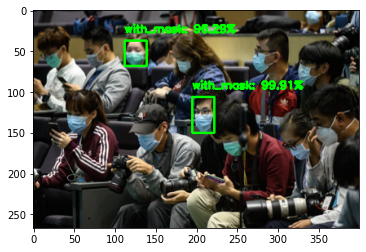

In [9]:
# test on one image
detect('/Users/claireph/DSI/Submissions/projects/capstone/data/images/maksssksksss247.png', 165, 0.5)

error with image /Users/claireph/DSI/Submissions/projects/capstone/data/images/maksssksksss446.png
error with image /Users/claireph/DSI/Submissions/projects/capstone/data/images/maksssksksss811.png


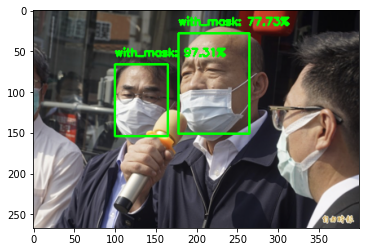

In [10]:
detections = []
for idx,image in enumerate(image_directories):
    
    imageId = idx
    try:
        detect(image, imageId, 0.3)
    except:
        print(f'error with image {image}')

In [11]:
len(detections)

1662

In [12]:
detections_df = pd.DataFrame(detections, columns=['image', 'label', 'color', 'startX', 'startY', 'endX', 'endY'])

In [13]:
detections_df.head()

,image,label,color,startX,startY,endX,endY
0,maksssksksss0.png,without_mask: 92.23%,"(0, 0, 255)",322,78,362,143
1,maksssksksss0.png,with_mask: 52.30%,"(0, 255, 0)",75,101,117,139
2,maksssksksss1.png,with_mask: 98.51%,"(0, 255, 0)",76,45,111,92
3,maksssksksss1.png,with_mask: 99.34%,"(0, 255, 0)",223,27,259,71
4,maksssksksss1.png,with_mask: 99.77%,"(0, 255, 0)",319,26,352,67


In [14]:
detection_count = pd.DataFrame(detections_df.groupby('image')['label'].count())

In [15]:
face_detection_count_df = pd.merge(face_df, detection_count, on='image', how = 'left')

In [16]:
face_detection_count_df.columns = ['image', 'face_count', 'detected']
face_detection_count_df.fillna(0, inplace=True)
face_detection_count_df['diff'] = face_detection_count_df['face_count'] - face_detection_count_df['detected']

In [17]:
face_detection_count_df.sort_values('diff', ascending=False)

,image,face_count,detected,diff
468,maksssksksss52.png,28,9.0,19.0
219,maksssksksss296.png,31,13.0,18.0
170,maksssksksss251.png,24,6.0,18.0
180,maksssksksss260.png,21,7.0,14.0
773,maksssksksss795.png,21,10.0,11.0
...,...,...,...,...
386,maksssksksss446.png,1,2.0,-1.0
207,maksssksksss285.png,1,2.0,-1.0
794,maksssksksss813.png,1,3.0,-2.0
107,maksssksksss195.png,1,3.0,-2.0


In [18]:
face_detection_count_df[face_detection_count_df['diff'] > 0].sum()

image         maksssksksss0.pngmaksssksksss1.pngmaksssksksss...
face_count                                                 2156
detected                                                    970
diff                                                       1186
dtype: object

In [19]:
face_detection_count_df[face_detection_count_df['diff'] < 0].sum()

image         maksssksksss101.pngmaksssksksss113.pngmaksssks...
face_count                                                   58
detected                                                    106
diff                                                        -48
dtype: object